# New approach to evaluating models  
#### Joshua Poirier, [NEOS](http://www.neosgeo.com)  
2016 SEG Machine Learning Contest  

## 1 Introduction  

The purpose of this notebook is to establish a new approach to evaluating models for this contest.  I propose a method which borrows from the **K-Folds** and **Leave-one-out** methods, wherein we build the model several times; each model is built by leaving out one well as the test set.  This method is designed to circumvent the circumstances of the contest wherein the prediction capability for the predefined blind well (**Newby**) is a loss function - leading to overfitting.  

Time to load supporting libraries and the data!

In [2]:
# visualization packages
library(repr)
library(ggplot2)
library(ggthemes)
library(cowplot)

# machine learning packages
library(e1071)
library(caret)

In [3]:
# load data
fname <- "../facies_vectors.csv"
data <- read.csv(fname, colClasses=c(rep("factor",3), rep("numeric",6), "factor", "numeric"))

# convert NM_M channel into a binary channel "isMarine"
data$NM_M <- data$NM_M == "2"
names(data)[10] <- "isMarine"

# make the Facies channel more descriptive
levels(data$Facies) <- c("SS", "CSiS", "FSiS", "SiSh", "MS", "WS", "D", "PS", "BS")

# remove any incomplete records (we know from jpoirier001.ipynb PE channel is missing some values)
data <- data[complete.cases(data),]

# display first five rows of data set
head(data)

Facies,Formation,Well.Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,isMarine,RELPOS
FSiS,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,FALSE,1.000
FSiS,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,FALSE,0.979
FSiS,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,FALSE,0.957
FSiS,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,FALSE,0.936
FSiS,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,FALSE,0.915
FSiS,A1 SH,SHRIMPLIN,2795.5,73.97,0.636,14.0,13.385,3.6,FALSE,0.894


## 2 Tuning SVM parameters

Noww let's apply our well-folds methodology wherein we loop through the wells and the current well iteration functions as the cross-validation data set while the remaining wells function as the training data.  Our tuning in *jpoirier001.ipynb* found that (using the randomly split data) the optimal SVM parameters were 10 for **Cost** and 1 for **Gamma**.  The tuning function tried **Cost** values of 0.01, 1, 5, 10, 20, 50, 100, 1000, 5000, and 10000 and **Gamma** values of 0.0001, 0.001, 0.01, 1, and 10.  Since we're going to apply this computationally intensive procedure multiple times, let's trim off a few of the end values.  

Also note that we will not isolate the **Recruit F9** "well" because it is not a true well but a manually selected set of observations of the Bafflestone facies.  

Let's start by building a function which tunes an SVM (Support Vector Machine) model.  We'll have it taken in two parameters:  **data** which is a data frame containing all observations from all wells, and **well** which is a string identifying which well should be used as the cross-validation set.  The function will start out by isolating the given well's data followed by tuning the SVM algorithm using a variety of **Cost** and **Gamma** parameters.  It then returns a list of each parameter pair and their associated performance.  Please note, this function may take several (if not tens of) minutes to complete. 

In [7]:
# WARNING: this function will take several minutes to complete
tune_svm <- function(data, well) {
    set.seed(3124)
    
    # isolate the well data
    cvIndex <- data$Well.Name == well
    cv <- data[cvIndex,]
    
    # apply tuning and return performances
    tune.out <- tune(svm, Facies ~ ., data=cv, 
                 kernel="radial",
                 ranges=list(cost=c(16,18,20,22,24,26,28,30,32,34),
                            gamma=c(.05,.1,.15,.2,.25,.3,.35,.4,.45,.5)))
    
    tune.out$performances
}

Now let's implement a new cross-validation method.  I'm calling it **Well-Folds**.  It combines the ideas behind **K-folds** and **leave-one-out**.  The idea is to **leave-one-out** where *one* is an entire well of observations.  It is similar to **K-folds** in that we are folding over the data set.  

Why **Well-Folds**?  In this type of geoscience problem we are interested in developing a predictive model to classify facies for wells which do not have facies data recorded from core.  While classic machine learning problems are focused on predicting the outcome of a new observation, this geoscience application is interested in predicting the outcome (facies) for a set of observations from a new well.  The **Well-Folds** method best simulates this.  

Let's now define the **Wells-fold** function.  It will take in two parameters.  The first parameter, **data**, is simply the data frame containing the observations for all wells.  The second parameter, **fxn**, is a function which is to be applied for each well in the **data** data frame.

In [17]:
 well_folds_cv <- function(data, fxn) {
    # list of wells
    wells <- unique(data$Well.Name)
    wells <- wells[-(which(wells == "Recruit F9"))]
    
    # initialize performances data frame
    performances <- data.frame(cost=numeric(), gamma=numeric(), error=numeric(), dispersion=numeric(), well=factor())
    
    # tune algorithm for each well, record and return performance
    for (well in wells) {
        temp <- fxn(data, well)
        temp$well <- well
        performances <- rbind(performances, temp)
    }
     
    # return data frame of parameters (incl. well) and their performance
    performances
}

Now that we have our cross-validation (**well-folds**) and tuning functions (**tune_svm**) defined, let's apply them to our data set and preview the resulting parameters and performances.

In [18]:
# tune the svm parameters
# WARNING: this task can take several minutes (if not tens of minutes) to complete
tuning <- well_folds_cv(data, tune_svm)
head(tuning)

cost,gamma,error,dispersion,well
16,0.05,0.1379876,0.04724347,SHRIMPLIN
18,0.05,0.1401152,0.04720575,SHRIMPLIN
20,0.05,0.1337323,0.05207576,SHRIMPLIN
22,0.05,0.1358599,0.05504759,SHRIMPLIN
24,0.05,0.1337323,0.05758017,SHRIMPLIN
26,0.05,0.1337323,0.05110074,SHRIMPLIN


From the first few rows of the tuning results we can see that the model performance (measured by error and dispersion) vary depending on the **Cost** and **Gamma** values.  For each **Cost/Gamma** pair, we have an **error** for each well.  Now let's average those performance figures across the different wells for each **Cost/Gamma** pair and output those parameters which minimize the average error.

In [15]:
# extract the unique cost and gamma values used
costs <- unique(tuning$cost)
gammas <- unique(tuning$gamma)

# initialize dataframe for statistics
df <- data.frame(cost=numeric(), 
                 gamma=numeric(), 
                 mean_error=numeric(), 
                 sd_error=numeric())

# loop through costs and gammas vectors, calculate performance stats for each pair
for (cost in costs) {
    for (gamma in gammas) {
        # retrieve rows for current cost and gamma values
        temp <- tuning[tuning$cost == cost & tuning$gamma == gamma,]
        
        # calculate mean and standard deviation of error
        mean_error <- mean(temp$error)
        sd_error <- sd(temp$error)
        
        # add the calculated stats to dataframe
        df <- rbind(df, data.frame(cost=cost, 
                                   gamma=gamma, 
                                   mean_error=mean_error, 
                                   sd_error=sd_error))
    }
}

# identify parameters with minimum average error
dfmin <- df[which.min(df$mean_error),]
round(dfmin,2)

,cost,gamma,mean_error,sd_error
32,22,0.1,0.16,0.06


This is interesting.  In *jpoirier001.ipynb* our random tuning (using a wider range of parameters) identified a **Cost** of 10 and **Gamma** of 1 to be optimal.  Here, we've found that a **Cost** of 22 and **Gamma** of 0.1 performs best.  To paint a more visual portrait of how the **Cost** and **Gamma** parameter selection influence model performance.  

Let's graph the average and standard deviation of the **Error**.  Minimizing the average **Error** will give us the ideal parameters, while the **Standard Deviation** will give us an idea of the uncertainty.

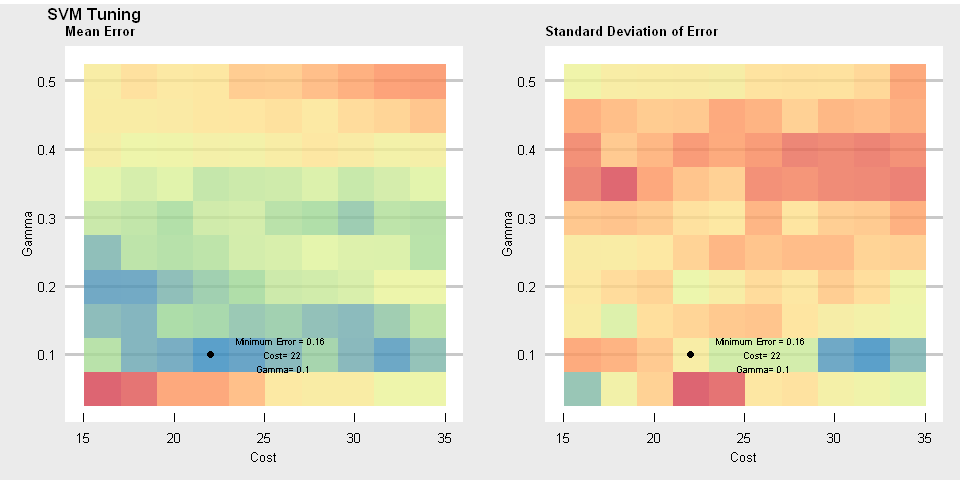

In [16]:
options(repr.plot.width=8, repr.plot.height=4)

# mean error across wells
g1 <- ggplot(df, aes(cost, gamma, fill=mean_error)) + theme_economist_white(gray_bg=T) +
    geom_raster(alpha=.8) +
    geom_point(data=dfmin, aes(cost, gamma)) +
    geom_text(aes(x=dfmin$cost[1]+4, y=dfmin$gamma[1], 
                  label=paste("Minimum Error =", round(dfmin$mean_error,2), 
                              "\n Cost=", dfmin$cost[1], "\n Gamma=", dfmin$gamma[1])), 
              size=2) +
    labs(x="Cost", y="Gamma", title="Mean Error") +
    scale_fill_distiller(palette="Spectral", name="", direction=-1) +
    theme(legend.position='none', 
          plot.title=element_text(size=8), 
          axis.text=element_text(size=8),
          axis.title=element_text(size=8),
          legend.text=element_text(size=8))

# standard deviation of errors across wells
g2 <- ggplot(df, aes(cost, gamma, fill=sd_error)) + theme_economist_white(gray_bg=T) +
    geom_raster(alpha=.8) +
    geom_point(data=dfmin, aes(cost, gamma)) +
    geom_text(aes(x=dfmin$cost[1]+4, y=dfmin$gamma[1], 
                  label=paste("Minimum Error =", round(dfmin$mean_error,2), 
                              "\n Cost=", dfmin$cost[1], "\n Gamma=", dfmin$gamma[1])), 
              size=2) +
    labs(x="Cost", y="Gamma", title="Standard Deviation of Error") +
    scale_fill_distiller(palette="Spectral", name="", direction=-1) +
    theme(legend.position='none', 
          plot.title=element_text(size=8), 
          axis.text=element_text(size=8),
          axis.title=element_text(size=8),
          legend.text=element_text(size=8))

# bring two plots together and display
g <- plot_grid(g1, g2, ncol=2)
ggdraw() + 
    draw_plot(g, width=1, height=1, y=-.01) + 
    draw_plot_label("SVM Tuning", size=10)

The raster plot of the standard deviations do not suggest some anomalous results.  The standard deviation of the minimum error is middling (yellow) - and that's ok.  Let's move forward using these parameters.  

## Building and evaluating a classification model  
